This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

## Coronal Parameters

Defining our source

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.0478E+04 G

Coronal Particle Number Density:
 n_c = 3.4392E+10 cm-3

Coronal Temperature:
 T_c = 2.5282E+09 K

Width of the current sheet:
 delta_RX = 1.6649E+11 cm

Reconnection Power:
 wdot_B = 5.9912E+42 erg s-1


## Maximum Accelerating Energy:

Larmor radius:

$$ r_{L} = 33.36 \text{km} \left( \frac{E}{\text{GeV}} \right) \left( \frac{1}{Z} \right) \left( \frac{\text{G}}{B} \right) $$

Maximum energy, in which the particle is able to escape our acceleration region only after the condition $r_{L} = \Delta R_{X}$ is achieved.

$$ \Delta R_{X} = 33.36 km \left( \frac{E}{\text{GeV}} \right) \left( \frac{1}{Z} \right) \left( \frac{\text{G}}{B} \right) $$

Hence, the energy (in GeV) will be

$$ E = \frac{\Delta R_{X} \cdot Z \cdot B}{33.36 \, \text{km} \cdot \text{G}} $$

And by this estimate, we can accelerate protons up to:

In [4]:
Z = 1.0 # proton case

Emax_p = (delta_RX * Z * B_c) / (33.36 * km )

print(f"Maximum Energy for proton (Emax_p) = {Emax_p:.2e} GeV")
print(f"Maximum Energy for proton (Emax_p) = {Emax_p * 1e9:.2e} eV")
print(f"Maximum Energy for proton (Emax_p) = {Emax_p * GeV:.2e} erg")

Maximum Energy for proton (Emax_p) = 5.23e+08 GeV
Maximum Energy for proton (Emax_p) = 5.23e+17 eV
Maximum Energy for proton (Emax_p) = 8.38e+05 erg


and then drift acceleration will act for energies at which the Larmor radius becomes larger than the thickness of the reconnection region.

The electrons may escape before the protons, given their difference in mass, therefore, we should use the mass ratio between them:

$$ \text{Emax_electron} = \text{Emax_proton} \times \left( \frac{\text{mass_e}}{\text{mass_p}} \right)  $$

In [5]:
Emax_e = Emax_p * me / mp

print(f"Maximum Energy for electron (Emax_e) = {Emax_e:.2e} GeV")
print(f"Maximum Energy for electron (Emax_e) = {Emax_e * 1e9:.2e} eV")
print(f"Maximum Energy for electron (Emax_e) = {Emax_e * GeV:.2e} erg")

Maximum Energy for electron (Emax_e) = 2.85e+05 GeV
Maximum Energy for electron (Emax_e) = 2.85e+14 eV
Maximum Energy for electron (Emax_e) = 4.56e+02 erg


In [6]:
mp / me

1836.1454776986157

In [7]:
me / mp

0.000544619155805333

In [8]:
R_s

5920000000000.0

In [9]:
coronal_data.q

0.8200705800826866

In [10]:
## Energy range for protons and electrons [erg]

Ep = np.linspace(1e6, 1e20) * eV
Ee = np.linspace(1e6, 1e20) * eV

In [16]:
## Xu & Lazarian - 3rd Regime

v_in = 0.05 * va
beta_in = v_in / c
d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )

d_ur # [adim.]

0.01966916741367544

In [17]:
t_acc = 4*delta_RX / (c*d_ur)
t_acc # [s]

1129.4022114212746

In [18]:
# def time_acc_fermi(E):
#     '''Eq.(2.37) of Medina-Torrejon Thesis'''
#     alpha = 0.1
#     s = 1/alpha
#     E0 = 10**(4)
#     t0 = 700
#     ## hours
#     return s**(-1) * (E0/E)**(-1/s) * t0
#     # return (E0/E)**(-1/s) * t0


def time_acc_regime3(va, delta_RX):
    v_in = 0.05 * va
    beta_in = v_in / c
    d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )
    
    return 4 * delta_RX / (c * d_ur)


def time_acc_drift(E, B, va):
    '''Eq.(7) of Del Valle, de Gouveia Dal Pino & Kowal 2016 e de Gouveia Dal Pino & Kowal 2015'''
    v_rec = 0.05 * va
    
    return E / (qe*B*v_rec)

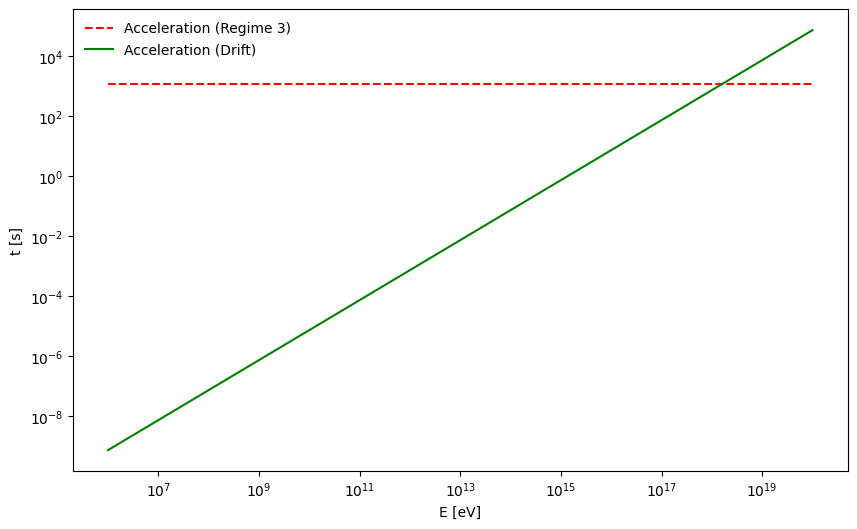

In [19]:
plt.figure(figsize=(10, 6))

plt.loglog(Ep/eV,[time_acc_regime3(va, delta_RX)]*len(Ep),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ep/eV,time_acc_drift(Ep, B_c, va),label='Acceleration (Drift)',color='green')

# plt.xlim()
# plt.ylim((1e-4,1e4))

# plt.title('Hadrons')
plt.xlabel('E [eV]')
plt.ylabel('t [s]')

# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/acc_reconnection_drift.png',dpi=300)

plt.legend(frameon=False)
plt.show()

In [20]:
# plt.figure(figsize=(10, 6))

# plt.loglog(Ee/eV,[time_acc_regime3(va, delta_RX)]*len(Ee),'--',label='Acceleration (Regime 3)',color='red')
# plt.loglog(Ee/eV,time_acc_drift(Ee, B_c, va),label='Acceleration (Drift)',color='green')

# # plt.xlim()
# # plt.ylim((1e-4,1e4))

# plt.title('Leptons')
# plt.xlabel('E [eV]')
# plt.ylabel('t [s]')

# # plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
# plt.savefig('plots/acc_reconnection_drift.png',dpi=300)

# plt.legend(frameon=False)
# plt.show()

In [21]:
## Normalizing

Ep_norm = Ep / (mpc2)
Ep_norm

array([1.06578902e-03, 2.17507964e+09, 4.35015929e+09, 6.52523893e+09,
       8.70031857e+09, 1.08753982e+10, 1.30504779e+10, 1.52255575e+10,
       1.74006371e+10, 1.95757168e+10, 2.17507964e+10, 2.39258761e+10,
       2.61009557e+10, 2.82760354e+10, 3.04511150e+10, 3.26261946e+10,
       3.48012743e+10, 3.69763539e+10, 3.91514336e+10, 4.13265132e+10,
       4.35015929e+10, 4.56766725e+10, 4.78517521e+10, 5.00268318e+10,
       5.22019114e+10, 5.43769911e+10, 5.65520707e+10, 5.87271504e+10,
       6.09022300e+10, 6.30773096e+10, 6.52523893e+10, 6.74274689e+10,
       6.96025486e+10, 7.17776282e+10, 7.39527079e+10, 7.61277875e+10,
       7.83028671e+10, 8.04779468e+10, 8.26530264e+10, 8.48281061e+10,
       8.70031857e+10, 8.91782654e+10, 9.13533450e+10, 9.35284246e+10,
       9.57035043e+10, 9.78785839e+10, 1.00053664e+11, 1.02228743e+11,
       1.04403823e+11, 1.06578902e+11])

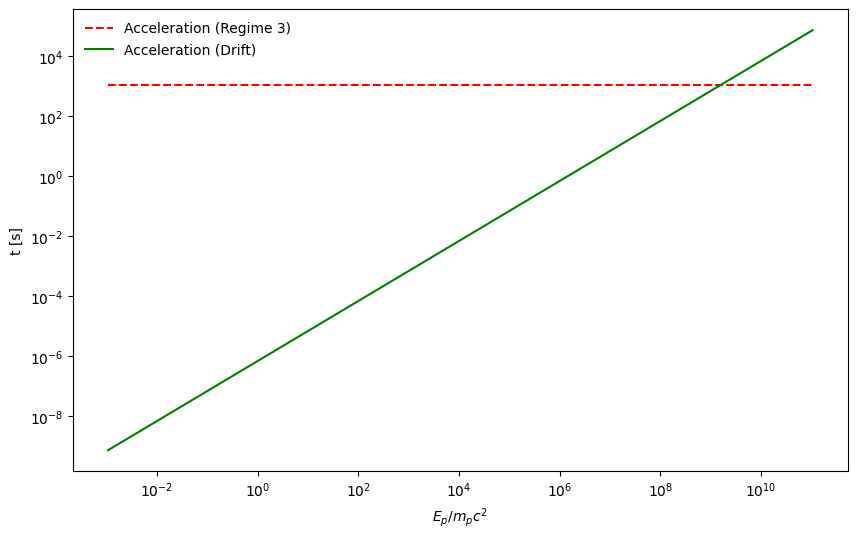

In [22]:
plt.figure(figsize=(10, 6))

plt.loglog(Ep_norm,[time_acc_regime3(va, delta_RX)]*len(Ep),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ep_norm,time_acc_drift(Ep, B_c, va),label='Acceleration (Drift)',color='green')

# plt.xlim()
# plt.ylim((1e-4,1e4))

# plt.title('Hadrons')
plt.xlabel(r'$E_p / m_p c^2$')
plt.ylabel('t [s]')

# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/acc_reconnection_drift_norm.png',dpi=300)

plt.legend(frameon=False)
plt.show()

## Testing Tania's curve

In [23]:
from astropy.io import fits

# Function to inspect the FITS file structure
def inspect_fits(file_path):
    with fits.open(file_path) as hdul:
        hdul.info()  # Print the structure of the FITS file
        for i, hdu in enumerate(hdul):
            print(f"HDU {i}:")
            print(repr(hdu.header))
            if hdu.data is not None:
                print(f"Data shape: {hdu.data.shape}")

# Inspect the FITS file structure
inspect_fits('./partic_dedEdt_en.fits')

Filename: ./partic_dedEdt_en.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (3, 61)   float64   
HDU 0:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    3                                                  
NAXIS2  =                   61                                                  
EXTEND  =                    T                                                  
VAR     = 'Acceleration time'                                                   
Data shape: (61, 3)


In [24]:
from astropy.io import fits

# Function to read the .fits file and extract the columns
def readfits(file_path):
    with fits.open(file_path) as hdul:
        # Assuming the data is in the primary HDU
        data = hdul[0].data
    return data

# Read the .fits file
array = readfits('./partic_dedEdt_en.fits')  ## L / c

# Extract columns
tacc = array[:, 0]  # (Tempo de aceleração)
Eacc = array[:, 1]  # (Energy kinetica)
sdcc = array[:, 2]  # (desvio padrão, a observar)

In [25]:
# Print the extracted columns
# print("Tempo de aceleração:", tacc)
# print("Energy kinetica:", Eacc)
# print("Desvio padrão:", sdcc)

In [26]:
# tacc

In [27]:
# Eacc

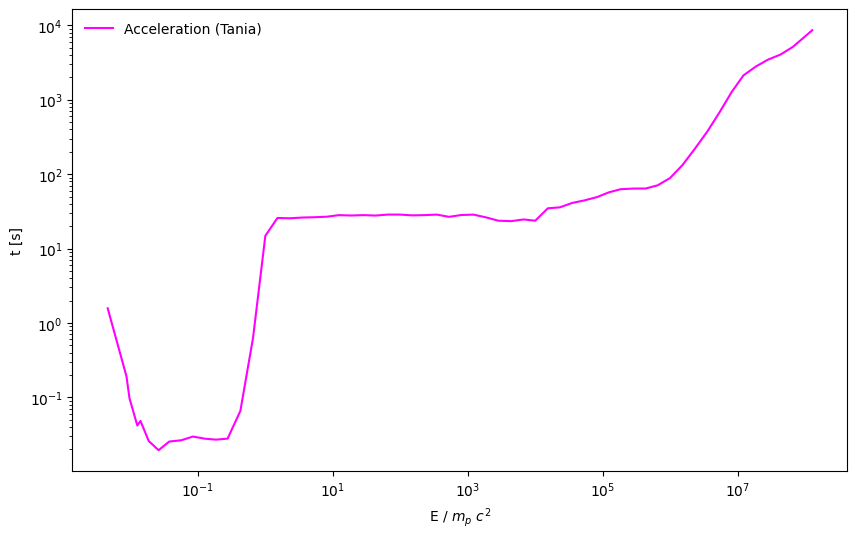

In [28]:
## Tania

plt.figure(figsize=(10, 6))

plt.loglog(Eacc,tacc,label='Acceleration (Tania)',color='magenta')

plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [s]')

plt.show()

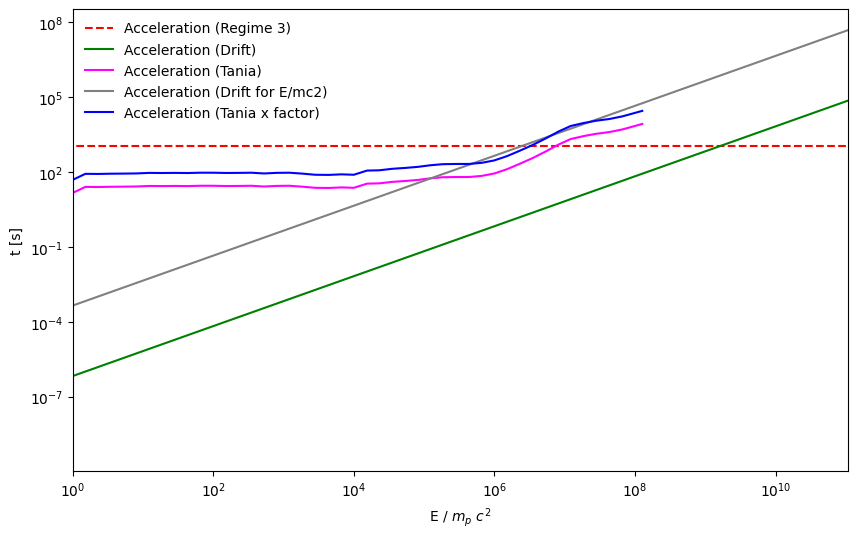

In [33]:
## erg

plt.figure(figsize=(10, 6))

plt.loglog(Ep_norm,[time_acc_regime3(va, delta_RX)]*len(Ep_norm),'--',label='Acceleration (Regime 3)',color='red')
plt.loglog(Ep_norm,time_acc_drift(Ep, B_c, va),label='Acceleration (Drift)',color='green')
plt.loglog(Eacc,tacc,label='Acceleration (Tania)',color='magenta')

plt.loglog(Ep_norm,time_acc_drift(Ep_norm, B_c, va),label='Acceleration (Drift for E/mc2)',color='gray')
plt.loglog(Eacc,tacc*(1e11/c),label='Acceleration (Tania x factor)',color='blue')
##### Tania's has a normalization factor

plt.xlim((1e0,Ep_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [s]')

plt.show()